# CT5107 Assignment 2
## MNIST Dataset analysis utilising the Keras library

**Student Name: **Kevin Derrane & Jamie O'Halloran

**Student ID: **12409118 & 12458152

This assignment was completed during the MSc Computer Science - Data Analytics.

In [ ]:
# Import relevant libraries. 
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.layers import Conv2D
from keras.layers import Input, Lambda
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

Using TensorFlow backend.


## 1. (Part 1): Program a network in Keras with a triplet loss function.

This following code, up to Part 4 is based off of the skeleton code keras_mnist_triplet_skeleton.py provided to us for this assignment. 


### ---------------------------- Data ------------------------------------------


In [ ]:
# load and shape data as usual, but here we don't process class labels
# to one-hot encoding. In fact, we don't exactly use class labels
# during training, only while setting up the triplets.
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

11493376/11490434 [==============================] - 1s 0us/step


In [ ]:
def get_image(label, test=False):
    """Choose an image from our training or test data with the
    given label."""
    if test:
        y = y_test; X = X_test
    else:
        y = y_train; X = X_train
    idx = np.random.randint(len(y))
    while y[idx] != label:
        # keep searching randomly!
        idx = np.random.randint(len(y))
    return X[idx]

In [ ]:
def get_triplet(test=False):
    """Choose a triplet (anchor, positive, negative) of images
    such that anchor and positive have the same label and
    anchor and negative have different labels."""
    n = a = np.random.randint(10)
    while n == a:
        # keep searching randomly!
        n = np.random.randint(10)
    a, p = get_image(a, test), get_image(a, test)
    n = get_image(n, test)
    return a, p, n

In [ ]:
def generate_triplets(test=False):
    """Generate an un-ending stream (ie a generator) of triplets for
    training or test."""
    while True:
        list_a = []
        list_p = []
        list_n = []

        for i in range(batch_size):
            a, p, n = get_triplet(test)
            list_a.append(a)
            list_p.append(p)
            list_n.append(n)
            
        A = np.array(list_a, dtype='float32')
        P = np.array(list_p, dtype='float32')
        N = np.array(list_n, dtype='float32')
        # a "dummy" label which will come in to our identity loss
        # function below as y_true. We'll ignore it.
        label = np.ones(batch_size) 
        yield [A, P, N], label

### ---------------------------- Loss ------------------------------------------

In [ ]:
def identity_loss(y_true, y_pred):
    """This loss function just takes the mean of y_pred. Because of the
    way we wire the network (see complete_model below), y_pred is the
    output of the triplet loss, so minimising it is what we want to
    do."""
    return K.mean(y_pred)

In [ ]:
def triplet_loss(x):
    """The triplet loss is ||A - P|| - ||A - N|| + alpha, where ||.||
    is the Euclidean norm. Notice that this is not a loss function in the
    format expected by Keras, ie f(y_true, y_pred)."""
    anchor, positive, negative = x
    
    # XXX YOUR CODE HERE: CALCULATE loss. USE K.
    positive_distance = K.sum(K.square(anchor-positive), axis=-1)
    negative_distance = K.sum(K.square(anchor-negative), axis=-1)
    loss =  K.sum(K.maximum(positive_distance - negative_distance + alpha, 0), axis=0)
    return loss

### ---------------------------- Model ------------------------------------------

In [ ]:
def embedding_model():
    """A tiny model similar to the network we used for MNIST
    classification. We assume the architecture should be good for
    MNIST embedding. Its input is an image and output is an embedding,
    not a classification, so the final layer is not a softmax. We
    don't compile or add a loss since this will become a component in
    the complete model below."""
    model = Sequential()
    input_shape = Input(shape=(imsize, imsize, 1))
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(embedding_dim, activation='sigmoid'))
    # XXX YOUR CODE HERE: ADD SOME LAYERS ENDING IN AN OUTPUT LAYER
    # APPROPRIATE FOR THE EMBEDDING.
    return model

In [ ]:
def complete_model(base_model):
    """This part of the model is quite tricky. Rather than a Sequential
    model, we declare a Model and say which are its inputs and
    outputs, and we declare how the outputs are calculated from the
    inputs. In particular, there are no layers in this model, *other
    than* the layers in the embedding model discussed above.

    A further complication is that our triplet loss can't be
    calculated as a function of y_true and y_predicted as
    usual. Instead we calculate the triplet loss as an extra Lambda
    layer. Then the Model's loss is set to be equal to the triplet
    loss via the identity function."""

    
    input_1 = Input((imsize, imsize, 1))
    input_2 = Input((imsize, imsize, 1))
    input_3 = Input((imsize, imsize, 1))

    # call the base_model three times to get A, P, N

    # XXX YOUR CODE HERE.
    A = base_model(input_1)
    P = base_model(input_2)
    N = base_model(input_3)
    loss = Lambda(triplet_loss)([A, P, N]) 
    model = Model(inputs=[input_1, input_2, input_3], outputs=loss)
    model.compile(loss=identity_loss, optimizer=Adam(LR))
    return model



### ----------------------------Settings ------------------------------------------

In [ ]:
imsize = 28
# XXX you might like to play with some of these hyperparameters
batch_size = 100
# 2D is interesting for visualisation, but higher allows more "space"
# to achieve accuracy in complex domains, eg 128 is common for
# faces. but MNIST is simple, so maybe 2 is enough for us anyway.
embedding_dim = 2 
LR = 0.0001 # be careful: too large will be unstable for our data
EPOCHS = 5
alpha = 0.2 # interesting to think about different values

## 2. Train the network on the MNIST data.



### ----------------------------Main ------------------------------------------

In [ ]:
# create the data generators
train_generator = generate_triplets()
test_generator = generate_triplets(test=True)

# instantiate the model and take a look

# XXX YOUR CODE HERE: create the embedding model and then use
# that to create the complete model
base_model = embedding_model()
model = complete_model(base_model)
print(model.summary())

# fit

# XXX YOUR CODE HERE: call fit_generator() to fit the model.
# Assign the model to variable history                                    
history = model.fit_generator(train_generator,
                    validation_data = test_generator,
                    epochs = EPOCHS,
                    verbose = 2,
                    #steps_per_epoch=20, 
                    #validation_steps=30
                    steps_per_epoch=200, 
                    validation_steps=300
                    )

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2)            692930      input_2[0][0]                    
                                     

## 3. Report the value of the loss function over time, eg using a plot. 

### ---------------------------- Loss plot ------------------------------------------

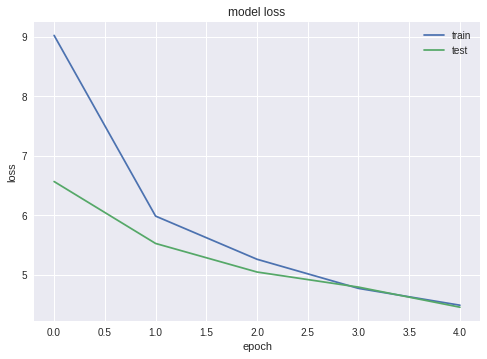

In [ ]:
# Loss plot for our model. 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


### ----------------------------Visualisation ------------------------------------------

In [ ]:
# we add an extra 28 pixels to allow for images whose bottom-left is
# at the top or right border
canvas_size = 4000
canvas = np.zeros((canvas_size+imsize, canvas_size+imsize), dtype=float)

def loc2pix(x, size):

    """All values in x are in [-1, 1], we want it in [0, size]."""
    # add 1 to make it non-negative, squeeze to remove trivial
    # dimension and transform.
    x = (((1.0 + x.squeeze()) / 2) * size).astype(int)
    assert np.all(x >= 0) and np.all(x < size)
    return x

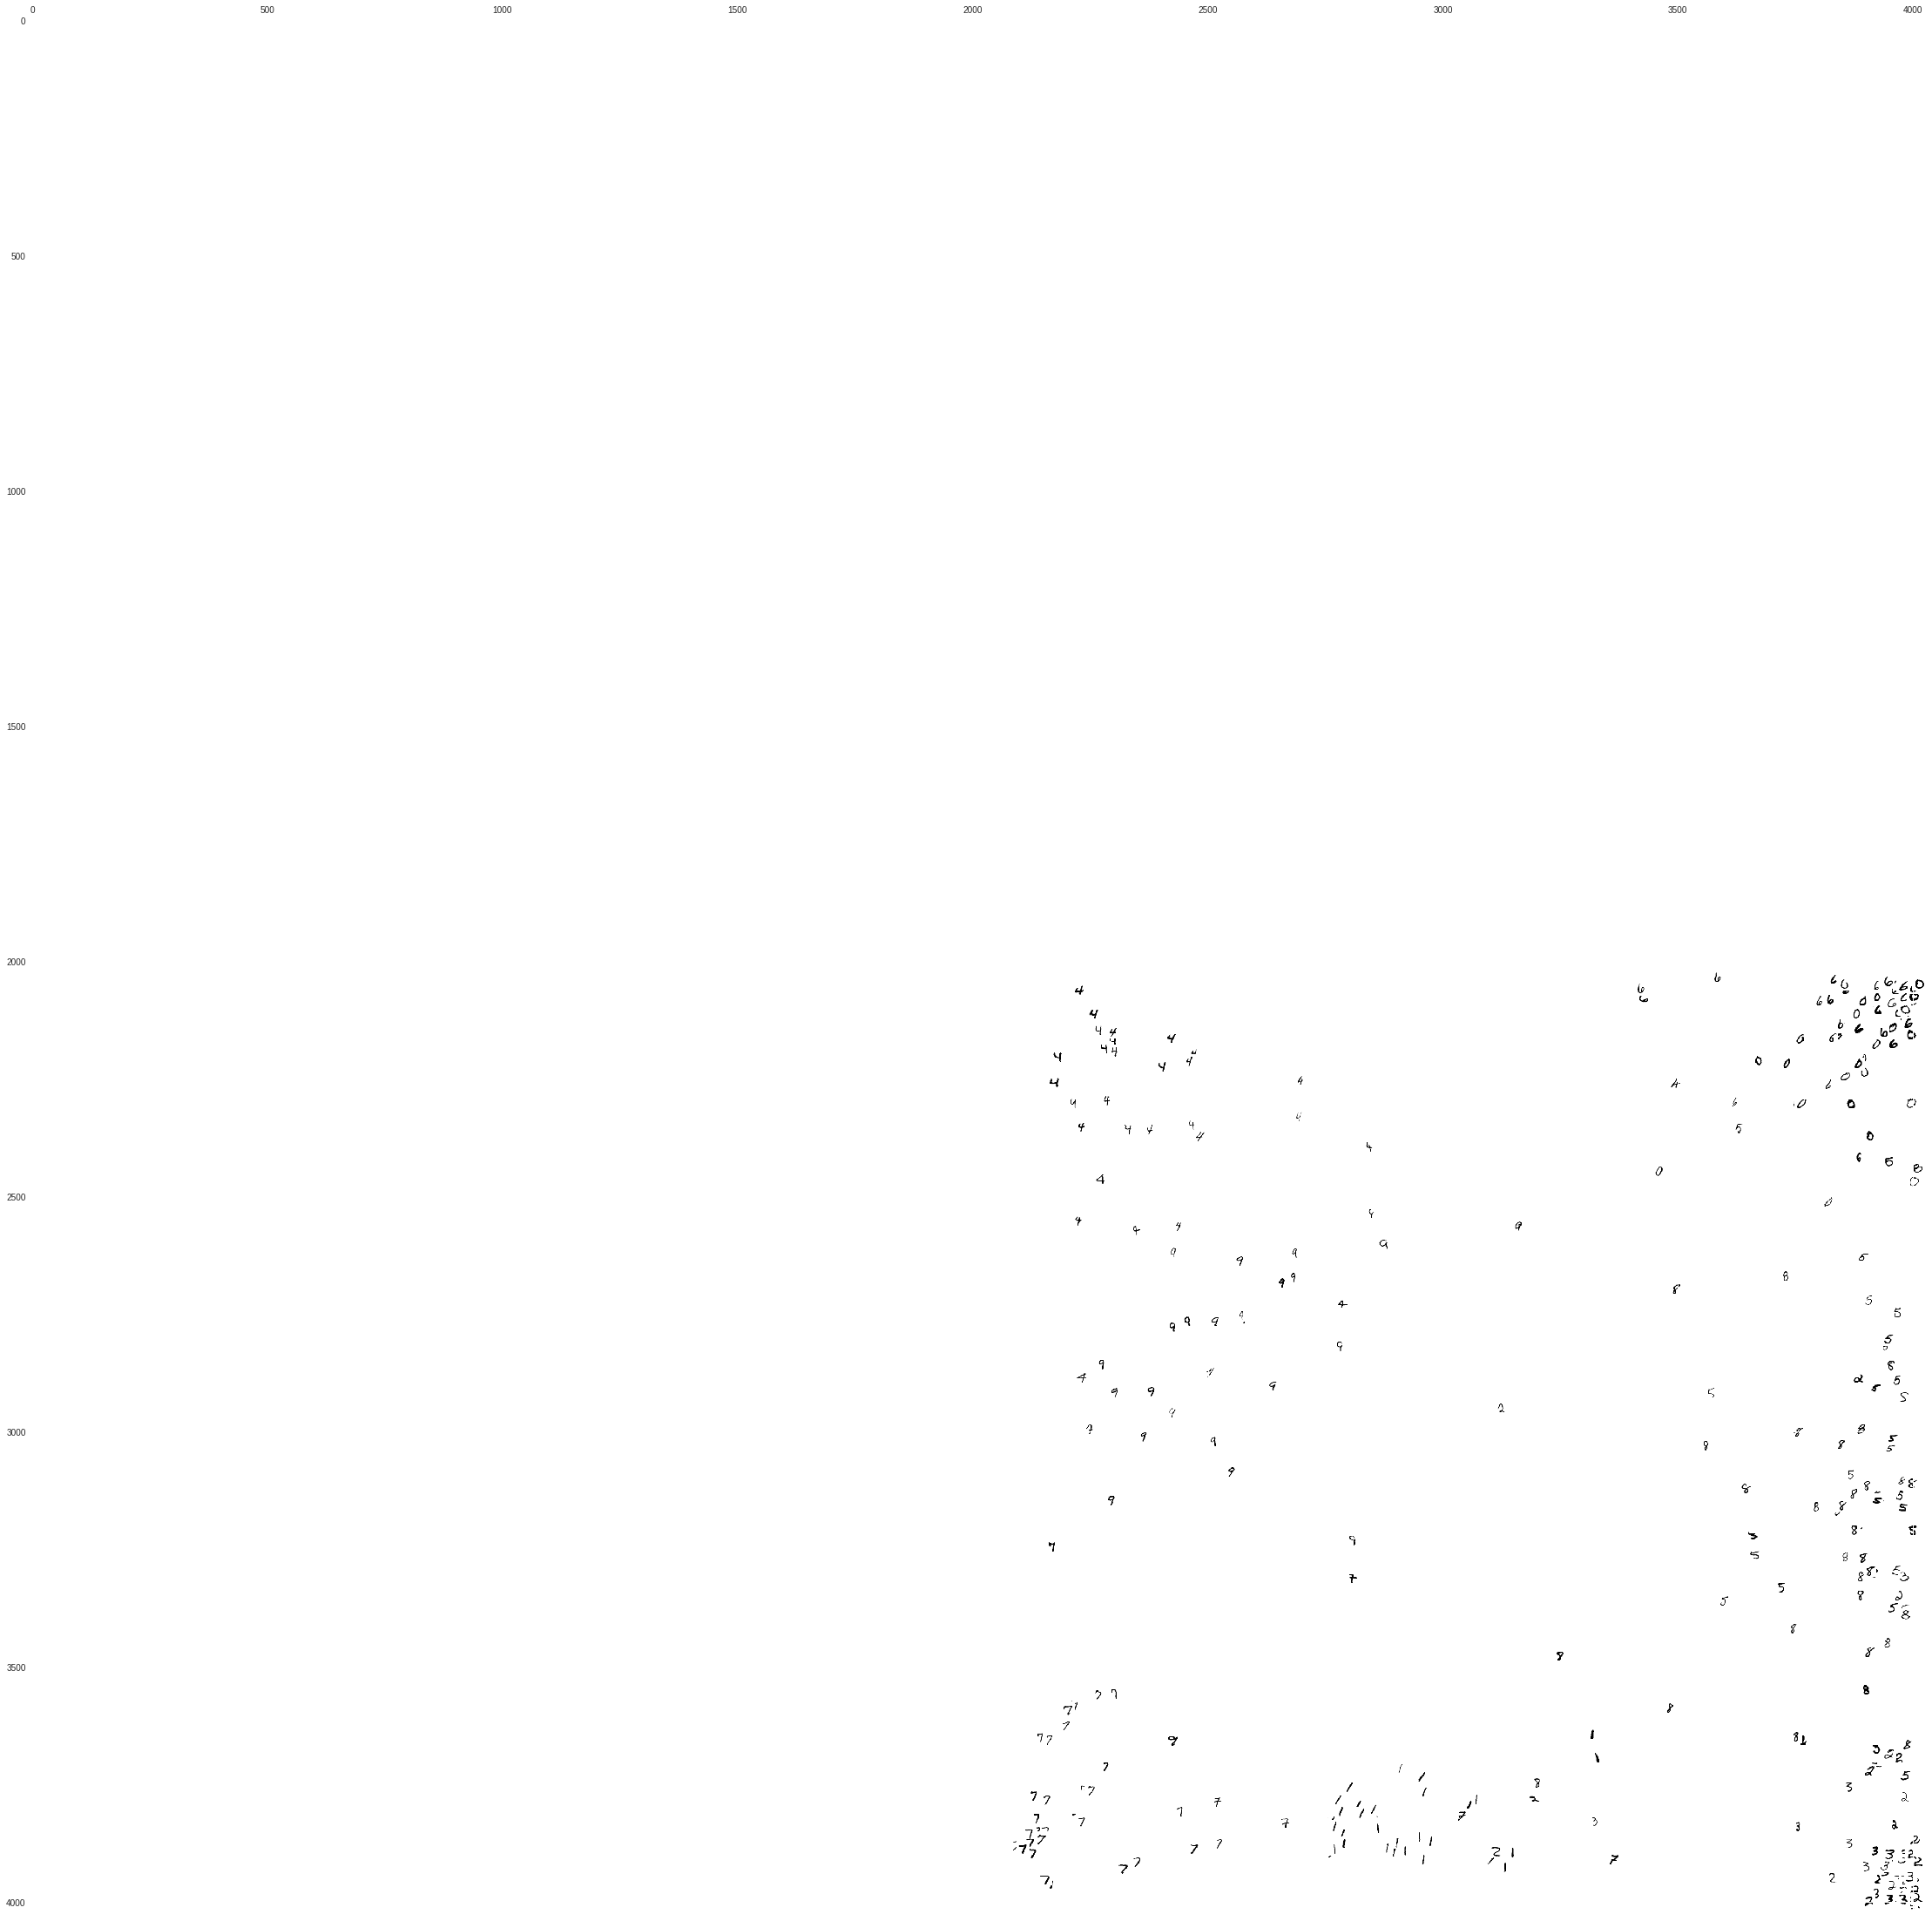

In [ ]:
for ib, batch in enumerate(test_generator):
    APN, label = batch
    for i in range(batch_size):
        
        # get the embedding for a, p, n: each should be in [-1, 1]^2
        
        # XXX YOUR CODE HERE. Set a to be the embedding of APN[0][i:i+1],
        # and similarly p for APN[1][i:i+1] and n for APN[2][i:i+1].
        # Think about what you need to call.
        
        a = base_model(tf.constant(APN[0][i:i+1]))
        p = base_model(tf.constant(APN[1][i:i+1]))
        n = base_model(tf.constant(APN[2][i:i+1]))
        a = K.eval(a)
        p = K.eval(p)
        n = K.eval(n)
        # transform a, p, n to pixel-space [0, 4028]^2
        a = loc2pix(a, canvas_size)
        p = loc2pix(p, canvas_size)
        n = loc2pix(n, canvas_size)

        # paint the image of each digit onto the canvas
        canvas[a[0]:a[0]+imsize, a[1]:a[1]+imsize] = APN[0][i].squeeze()
        canvas[p[0]:p[0]+imsize, p[1]:p[1]+imsize] = APN[1][i].squeeze()
        canvas[n[0]:n[0]+imsize, n[1]:n[1]+imsize] = APN[2][i].squeeze()
        
    break # one batch of 100 samples is enough for visualisation

fig, ax = plt.subplots(figsize=(40, 40)) # we have to make it large to avoid subsampling
ax.matshow(canvas)
plt.savefig("keras_mnist_triplet_layout.png")



## 4. Program a recognition function: given a new image, it should recognize the image as a digit (and which digit) or report (e.g. if the image is a letter, instead of a digit) that it is unknown. 

In [ ]:
# Reload the datasets to make own database for our digit recognition. 
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
database = {}
database['zero'] = test_images[3]
database['one'] = test_images[2]
database['two'] = test_images[1]
database['three'] = test_images[18]
database['four'] = test_images[4]
database['five'] = test_images[15]
database['six'] = test_images[4]
database['seven'] = test_images[0]
database['nine'] = test_images[9]

In [ ]:
# Convert to encoding for the digits. 
for (key, value) in database.items():
    tmp = database[key]
    tmp = tmp.astype('float32')
    tmp /= 255 
    tmp = np.reshape(tmp,(1,28,28,1))
    database[key] = base_model.predict(tmp)

## 5. Test the network with (unseen) images of letters (not numbers), to demonstrate that it works in this case.



In [ ]:
# Load unseen data and encode
# Make sure file emnist_train_images_3.npy is in directory 
unseen_images_data = np.load('emnist_train_images_3.npy')
unseen_images_data = unseen_images_data.astype('float32')

In [ ]:
# Loop and check the unseen_images_data to see if it is a number 
# compared to our database or a character. 
for i in range (len(unseen_images_data)):
    b = unseen_images_data[i]
    b /= 255
    b = np.reshape(b,(1,28,28,1))
    unseen_encoding = base_model.predict(b)
    best_dist = 10
    best_key = ""
    for key in database.keys():
        dist = np.linalg.norm(database[key] - unseen_encoding)
        if(best_dist>=dist):
            best_dist = dist
            best_key = key
    if (best_dist<0.07):
        print('it is number',best_key)
    else:
        print('not a number, unknown.')

not a number, unknown.
not a number, unknown.
not a number, unknown.


## 6. (Part 2): Find any pre-trained deep convolutional neural network face model on the internet which uses an embedding, a Siamese network, or a similar approach which allows you to carry out the final tasks as follows.

For the following, i had the files vgg_face_weights.h5 and the six images ('joly1.jpg','s1.jpg','joly2.jpg','joly3.jpg','s3.jpg','s2.jpg') stored on my google drive. To run these just store them in the directory and remove the ***"gdrive/My Drive/"***. The links for these files are the following:



1.   **vgg_face_weights.h5:**  https://drive.google.com/uc?id=1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo&export=download
2.   **images.zip:** https://drive.google.com/file/d/1p8QlRSm4f7muWCSKM8R-KlsNMfCZMLf1/view?usp=sharing



In [ ]:
# Only run if vgg_face_weights.h5 is stored in your google drive. 
# The Files are stored on my google drive. 
# Run below function to access these files 
# This was only for me as it took to long to upload the vgg_face_weights.h5 to 
# collab locally. 
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive



## 7. Use the output model (possibly after removing some final layers) to make face clusters, i.e. run a clustering algorithm so that multiple pictures of the same person are in the same cluster. This can run on any face dataset, whether open/public or your own. CLARIFICATION: you can use e.g. a Scikit-learn clustering algorithm, or a hand-written one. For each image in the dataset you’re going to cluster, you should pre-compute its embedding, and then work only with the embeddings. That is, don’t run all the images through the network at every step of the clustering algorithm.

Below is our VGG Face model. It is based off of the following pdf with help from the GITHUB below.. 

1.   http://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf
2.   https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3



Our model has 22 layers and 37 deep units.

In [ ]:
# Here we will be using the Sequential Keras model 
# The Sequential model is a linear stack of layers.
vgg_face_model = Sequential()

# Define the input shape. It is 224x224x3 sized images, where
# the number three is the RGB color of the input image. 
# Layers and deep units:
vgg_face_model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
vgg_face_model.add(Convolution2D(64, (3, 3), activation='relu'))
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(64, (3, 3), activation='relu'))
vgg_face_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(128, (3, 3), activation='relu'))
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(128, (3, 3), activation='relu'))
vgg_face_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(256, (3, 3), activation='relu'))
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(256, (3, 3), activation='relu'))
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(256, (3, 3), activation='relu'))
vgg_face_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_face_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_face_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
vgg_face_model.add(Convolution2D(4096, (7, 7), activation='relu'))
vgg_face_model.add(Dropout(0.5))
vgg_face_model.add(Convolution2D(4096, (1, 1), activation='relu'))
vgg_face_model.add(Dropout(0.5))
vgg_face_model.add(Convolution2D(2622, (1, 1)))
vgg_face_model.add(Flatten())
vgg_face_model.add(Activation('softmax'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


**Load the weights, define the depiction and preprocess the image:**

In [ ]:
# Files were stored in my google drive. If running locally uncomment below and 
# comment below it. 
# vgg_face_model.load_weights('vgg_face_weights.h5')
vgg_face_model.load_weights('gdrive/My Drive/vgg_face_weights.h5')

# The previous layer of the output layer will be used for depiction.
vgg_face_embedding = Model(input=vgg_face_model.layers[0].input,output=vgg_face_model.layers[-2].output)

# Preprocess the image. 
def image_preprocess(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("ze..., outputs=Tensor("fl...)`
  after removing the cwd from sys.path.


**Compare the vector representations:**

If the distance between the Cosine and Euclidiean distance is low we can say the images are of the same person. If they are far apart then they are not the same person. 

In [ ]:
# First we will find the cosine distance of each image. 
def cosine_Distance(source_rep, test_rep):
    a = np.matmul(np.transpose(source_rep), test_rep)
    b = np.sum(np.multiply(source_rep, source_rep))
    c = np.sum(np.multiply(test_rep, test_rep))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

# Then we will fine the Euclidean distance of each image.
def euclidean_Distance(source_rep, test_rep):
    eucl_dist = source_rep - test_rep
    eucl_dist = np.sum(np.multiply(eucl_dist, eucl_dist))
    eucl_dist = np.sqrt(eucl_dist)
    return eucl_dist

In [ ]:
# We then compare these distances above to see if both images are the same or not. 
# Our epilson is the value threshold. 
epsilon = 0.4
def compare_Faces(img1, img2):
  face1 = vgg_face_embedding.predict(image_preprocess(img1))[0,:] 
  face2 = vgg_face_embedding.predict(image_preprocess(img2))[0,:]
  
  # Calculate the vector representations of each image. 
  cosi_dist = cosine_Distance(face1, face2)
  eucl_dist = euclidean_Distance(face1, face2)
  
  # If is less than epsilon then its the same person and if 
  # its not then its a different person. 
  if(cosi_dist < epsilon):
    print("Same person detected. ")
  else:
    print("Different person detected. ")

**Test our model:**

In [ ]:
# Check out model on some of our images to see if it works. 
# Images are located in image.zip file linked above. 
# Put these images in local directory. 
compare_Faces('joly1.jpg','s1.jpg')
compare_Faces('joly1.jpg','joly2.jpg')

Different person detected. 
Same person detected. 


##  8. Demonstrate the clustering by showing on-screen or saving to disk a visualisation of 3 faces from each cluster, for at least 3 clusters.

In [ ]:
# Define the image paths. 
# Images are located in image.zip 
image_paths = ['joly1.jpg','s1.jpg','joly2.jpg','joly3.jpg','s3.jpg','s2.jpg']

# We clustered the images that were similar or of the same person with each other 
# using the DBSCAN (Density-based spatial clustering of applications with noise) 
# algorithm from scikit-learn.
X = []
for img in image_paths:
  img_encoding = vgg_face_embedding.predict(image_preprocess(img))[0,:]
  X.append(img_encoding)
  
face_cluster = DBSCAN(eps = 0.4, metric=cosine_Distance, min_samples=1)
face_cluster.fit(X)

DBSCAN(algorithm='auto', eps=0.4, leaf_size=30,
    metric=<function cosine_Distance at 0x7f8f73275510>,
    metric_params=None, min_samples=1, n_jobs=None, p=None)

In [ ]:
# Calculate the number of unique faces we have. 
face_IDs = np.unique(face_cluster.labels_)
num_faces = len(np.where(face_IDs > -1)[0])
print("Unique Faces = {}".format(num_faces))

Unique Faces = 2


**Plot the clusters:**

Face ID: 0


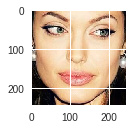

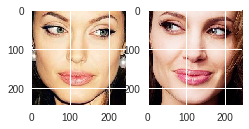

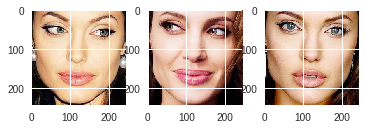

Face ID: 1


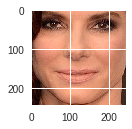

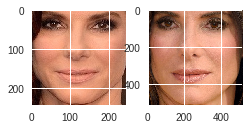

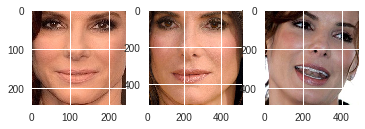

In [ ]:
# Loop through the different face_ID's
for face_ID in face_IDs: 
    
  # Find all indexes into that belong to the  current face ID, 
  # Randomly sample 26 of these indexes.  
  index = np.where(face_cluster.labels_ == face_ID)[0] 
  index = np.random.choice(index, size=min(26, len(index)), replace=False)
   
  # Create a list to hold the faces for each cluster. 
  faces = []
  
  # Title for plot. 
  print("Face ID: {}".format(face_ID))
  
  # Loop through our sample indexes taken above. 
  for i in index:
    
    # Load images from image_path defined above. 
    face = load_img(image_paths[i])
    # Add images to Face list above. 
    faces.append(face)
    
    # Define the size of the fgiure to hold the images. 
    columns = 3
    rows = 3
    fig_size = plt.figure(figsize=(8, 8))
    
    # Plot the images in each clusters 
    for i in range(len(faces)):
      img = faces[i]
      fig_size.add_subplot(4, 4, i+1)
      plt.imshow(img)
      # Save the cluster. 
      plt.savefig("clusters.png")
    # Show the clusters. 
    plt.show()